<a href="https://colab.research.google.com/github/xinnazim/esaa/blob/main/%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9Cch4_5_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

파이썬 딥러닝 텐서플로 ch4.5

pg. 229~240

# 07. 이미지 분할
: 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것
* 모든 픽셀은 클래스에 속함
  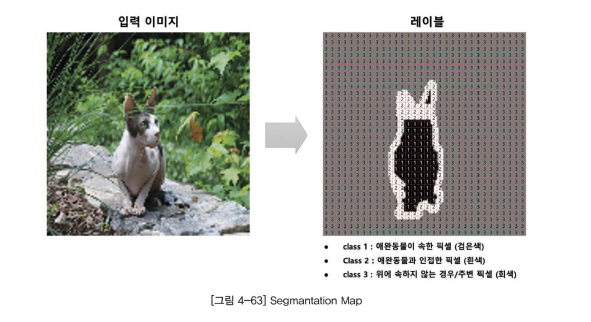


    


 * 이미지분할
    * 의미분할: 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분
    * 인스턴스 분할: 같은 범주여도 서로 다른 객체 구분

    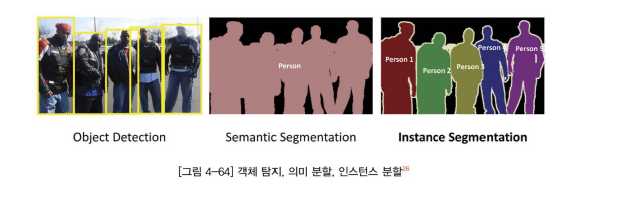

## 7-1 데이터셋 준비
* 예제에서 사용할 데이터셋: 반려동물의 이미지 및 분류 레이블

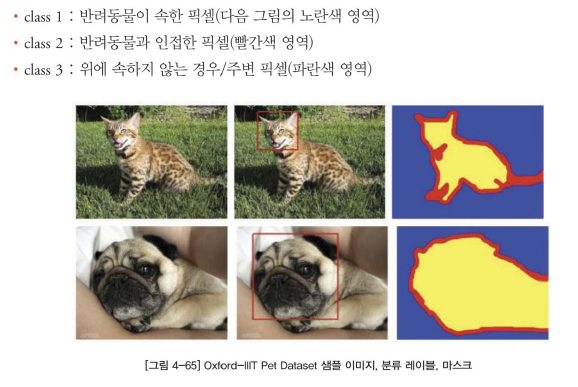

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

In [2]:
#이미지크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

옥스포드 반려동물 데이터 불러옴

In [3]:
# 텐서플로 데이터셋 로드
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteY4PUZ1/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteY4PUZ1/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


원본 이미지, 분할 마스크 전처리함수 정의
* 이미지 크기 128,128로 변경, 자료형 변환
* 픽셀 정규화

In [4]:
# 이미지 전처리 함수
def preprocess_image(ds):
  # 원본 이미지
  img = tf.image.resize(ds['image'],(img_w, img_h))
  img = tf.cast(img, tf.float32) / 255.0
  # 분할 마스크
  mask = tf.image.resize(ds['segmentation_mask'],(img_w, img_h))
  mask = tf.cast(mask, tf.int32)
  mask = mask - 1
  return img, mask

미니배치 분할

In [5]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


In [6]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

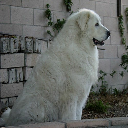

In [7]:
# 샘플 이미지 출력
img = np.array(img[0]) * 255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

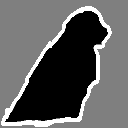

In [8]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2)*255.0
cv2_imshow(mask)

## 7-2 U-Net 모델(인코더-디코더)
* 사전학습된 VGG16 모델을 인코더로 활용하는 U-Net 모델 생성

In [9]:
# VGG16 모델
# 최종 레이어를 제외한 채로 불러옴
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


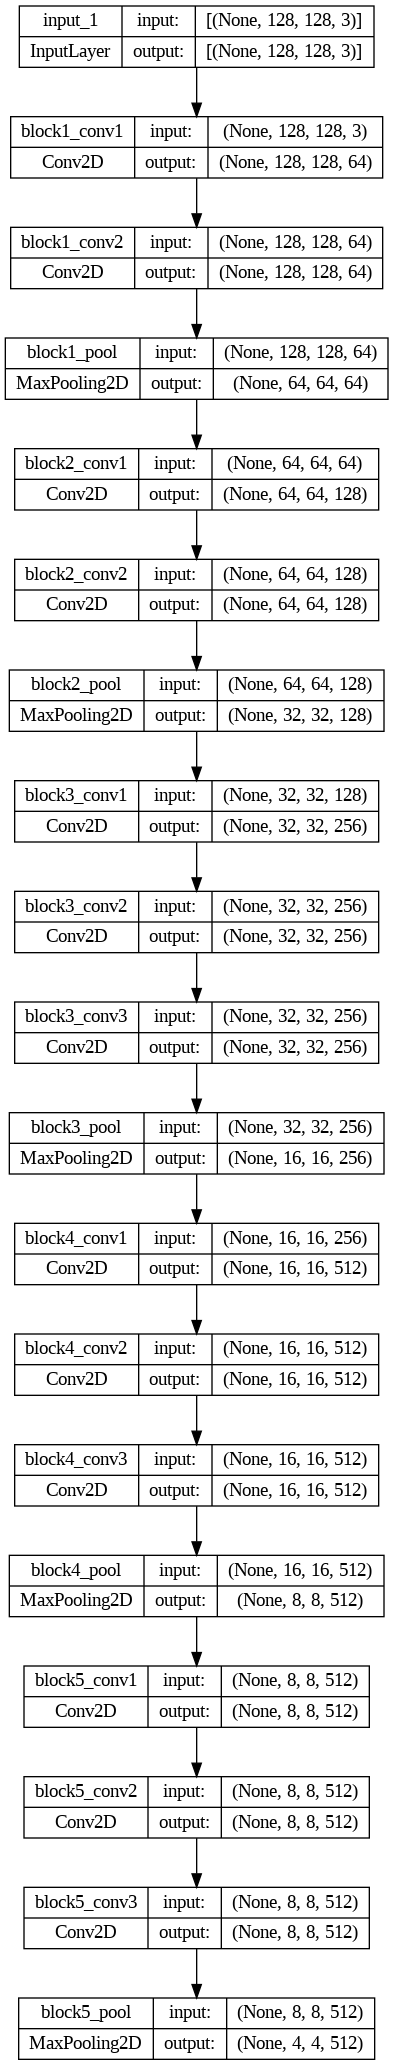

In [10]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes=True)

> 마지막 레이어에서 4,4 크기로 축소

In [11]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model = tf.keras.Model(inputs=[base_model.input],
                         outputs=[
                                  base_model.get_layer(name='block5_conv3').output,
                                  base_model.get_layer(name='block4_conv3').output,
                                  base_model.get_layer(name='block3_conv3').output,
                                  base_model.get_layer(name='block2_conv2').output,
                                  base_model.get_layer(name='block1_conv2').output,
                         ])

In [12]:
# 파라미터 고정
f_model.trainable = False

인코더 부분에서 5개의 출력 가져와 디코더의 입력으로 전달 -> 업샘플링(축소된 이미지를 복원)

In [13]:
# U-Net 구조로 모델 정의

i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same')(out)
out = tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])


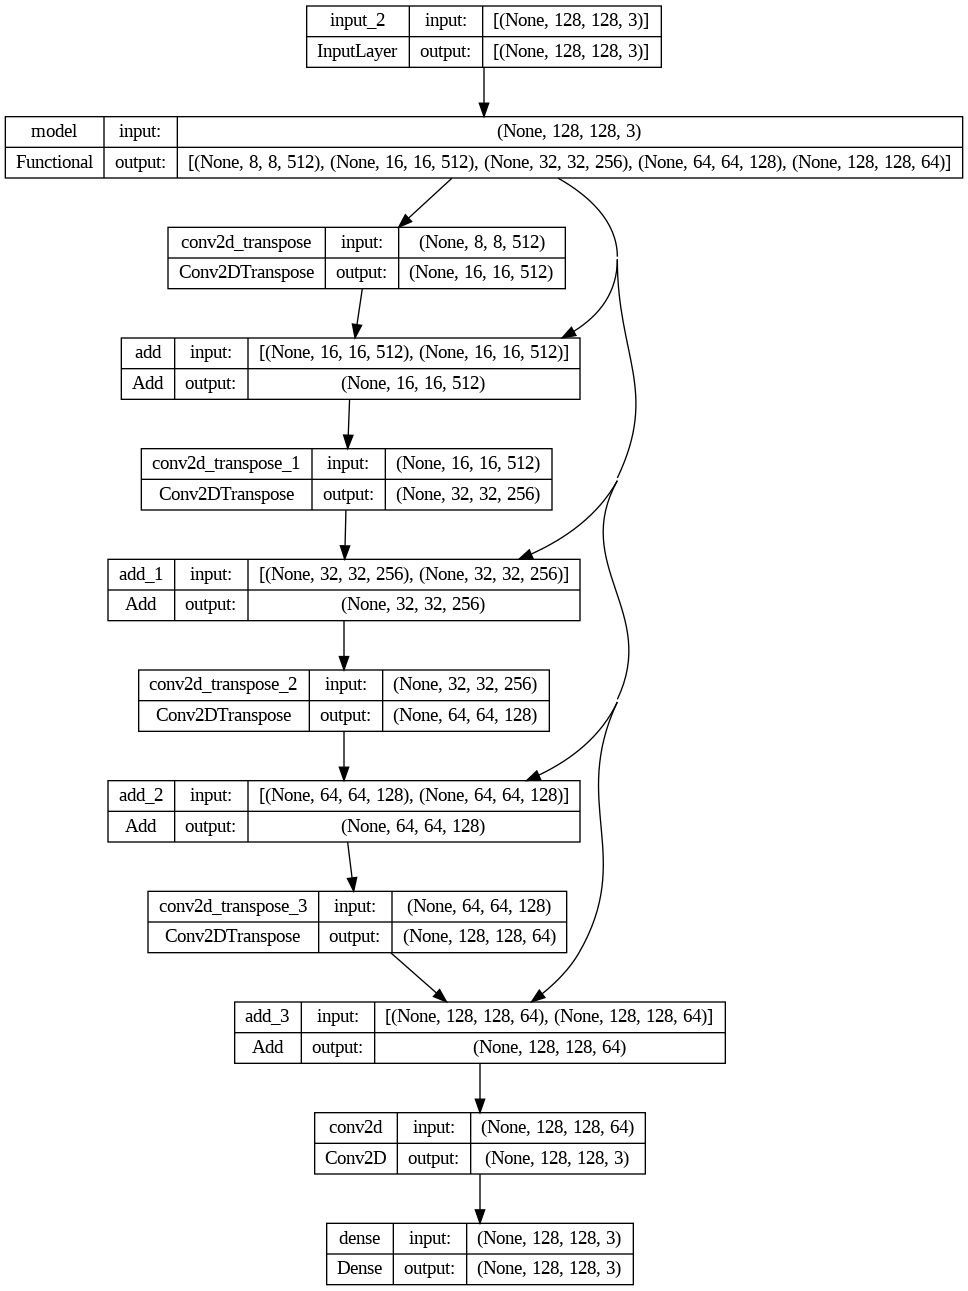

In [14]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

In [15]:
# 모델 요약
unet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          [(None, 8, 8, 512),          1471468   ['input_2[0][0]']             
                              (None, 16, 16, 512),        8                                       
                              (None, 32, 32, 256),                                                
                              (None, 64, 64, 128),                                                
                              (None, 128, 128, 64)]                                               
                                                                                            

* 예측 클래스 개수가 3개인 다중 분류 문제에 맞도록 SparseCategoricalCrossentropy 손실함수를 설정
* Adam 옵티마이저 적용

In [16]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 1542s 7s/step - loss: 0.9941 - accuracy: 0.5879
Epoch 2/5
230/230 [==============================] - 1426s 6s/step - loss: 0.6570 - accuracy: 0.7227
Epoch 3/5
230/230 [==============================] - 1420s 6s/step - loss: 0.5223 - accuracy: 0.7741
Epoch 4/5
230/230 [==============================] - 1430s 6s/step - loss: 0.4856 - accuracy: 0.7901
Epoch 5/5
230/230 [==============================] - 1402s 6s/step - loss: 0.4674 - accuracy: 0.7971


* 검증 셋의 배치를 하나 선택
* predict로 이미지 분할 클래스 예측


In [ ]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫 번째 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

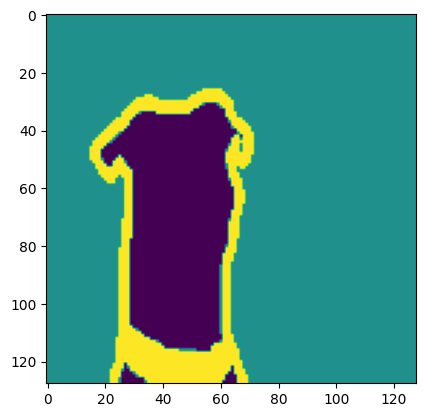

In [18]:
# 첫 번째 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0],(128,128)))

> 어느 정도 객체의 경계를 찾아냄